# Part 1. Create base grid with H3

### Import necessary modules

In [1]:
# Spatial
import geopandas as gpd
from geopandas.tools import sjoin

# Mapping / Plotting
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
import config

### Define area of interest

In [3]:
area = config.AREA_OF_INTEREST
print(area)

COUNTRY


### Functions for creating heaxgons

In [4]:
from create_hex import*

### Import layers to be used

In [5]:
## admininstrative boundary
if area == "COUNTRY":
    admin_gdf = gpd.read_file(config.ADMIN_PATH / config.ADMIN_GPKG, layer=config.ADMIN_LAYER_COUNTRY)
    region_gdf = gpd.read_file(config.ADMIN_PATH / config.ADMIN_GPKG, layer=config.ADMIN_LAYER_REGION)
else:    
    region_gdf = gpd.read_file(config.ADMIN_PATH / config.ADMIN_GPKG, layer=config.ADMIN_LAYER_REGION)
    region_gdf = region_gdf[region_gdf[config.ADMIN_REGION_COLUMN_NAME]==area]
    admin_gdf = region_gdf

In [6]:
print(admin_gdf.crs)

EPSG:4326


### H3 - Hexagon - grid

In [7]:
print("Creating a buffer to ensure full hexagon coverage...")
# Define buffer distance in meters.
buffer_distance_meters = config.buffer_distance_meters

# Store original CRS
original_crs = admin_gdf.crs
# Reproject to a projected CRS (e.g., a UTM zone) for accurate buffering in meters.
admin_gdf_proj = admin_gdf.to_crs(config.CRS_PROJ)

# Create a single unified geometry for buffering.
unified_geometry = admin_gdf_proj.union_all()
# Apply the buffer
buffered_geometry_proj = unified_geometry.buffer(buffer_distance_meters)

# Create a new GeoDataFrame for the buffered area
admin_gdf_buffered_proj = gpd.GeoDataFrame(geometry=[buffered_geometry_proj], crs=config.CRS_PROJ)
# Reproject the buffered GeoDataFrame back to the original CRS (WGS84)
admin_gdf_buffered = admin_gdf_buffered_proj.to_crs(original_crs)

print("Buffer created successfully.")

Creating a buffer to ensure full hexagon coverage...
Buffer created successfully.


In [8]:
size = config.HEX_SIZE ## resolution info here https://h3geo.org/docs/core-library/restable
# hexagons = feat(admin_gdf, size)
hexagons_unclipped = feat(admin_gdf_buffered, size)
print("Clipping hexagons and attaching region attributes...")
hexagons = gpd.sjoin(hexagons_unclipped,  region_gdf[[config.ADMIN_REGION_COLUMN_NAME, "geometry"]], how="inner", predicate="intersects")
# The sjoin adds an 'index_right' column
hexagons = hexagons.drop(columns=['index_right'])
hexagons = hexagons.drop_duplicates(subset='h3_index').reset_index(drop=True)


Clipping hexagons and attaching region attributes...


#### Select base map grid

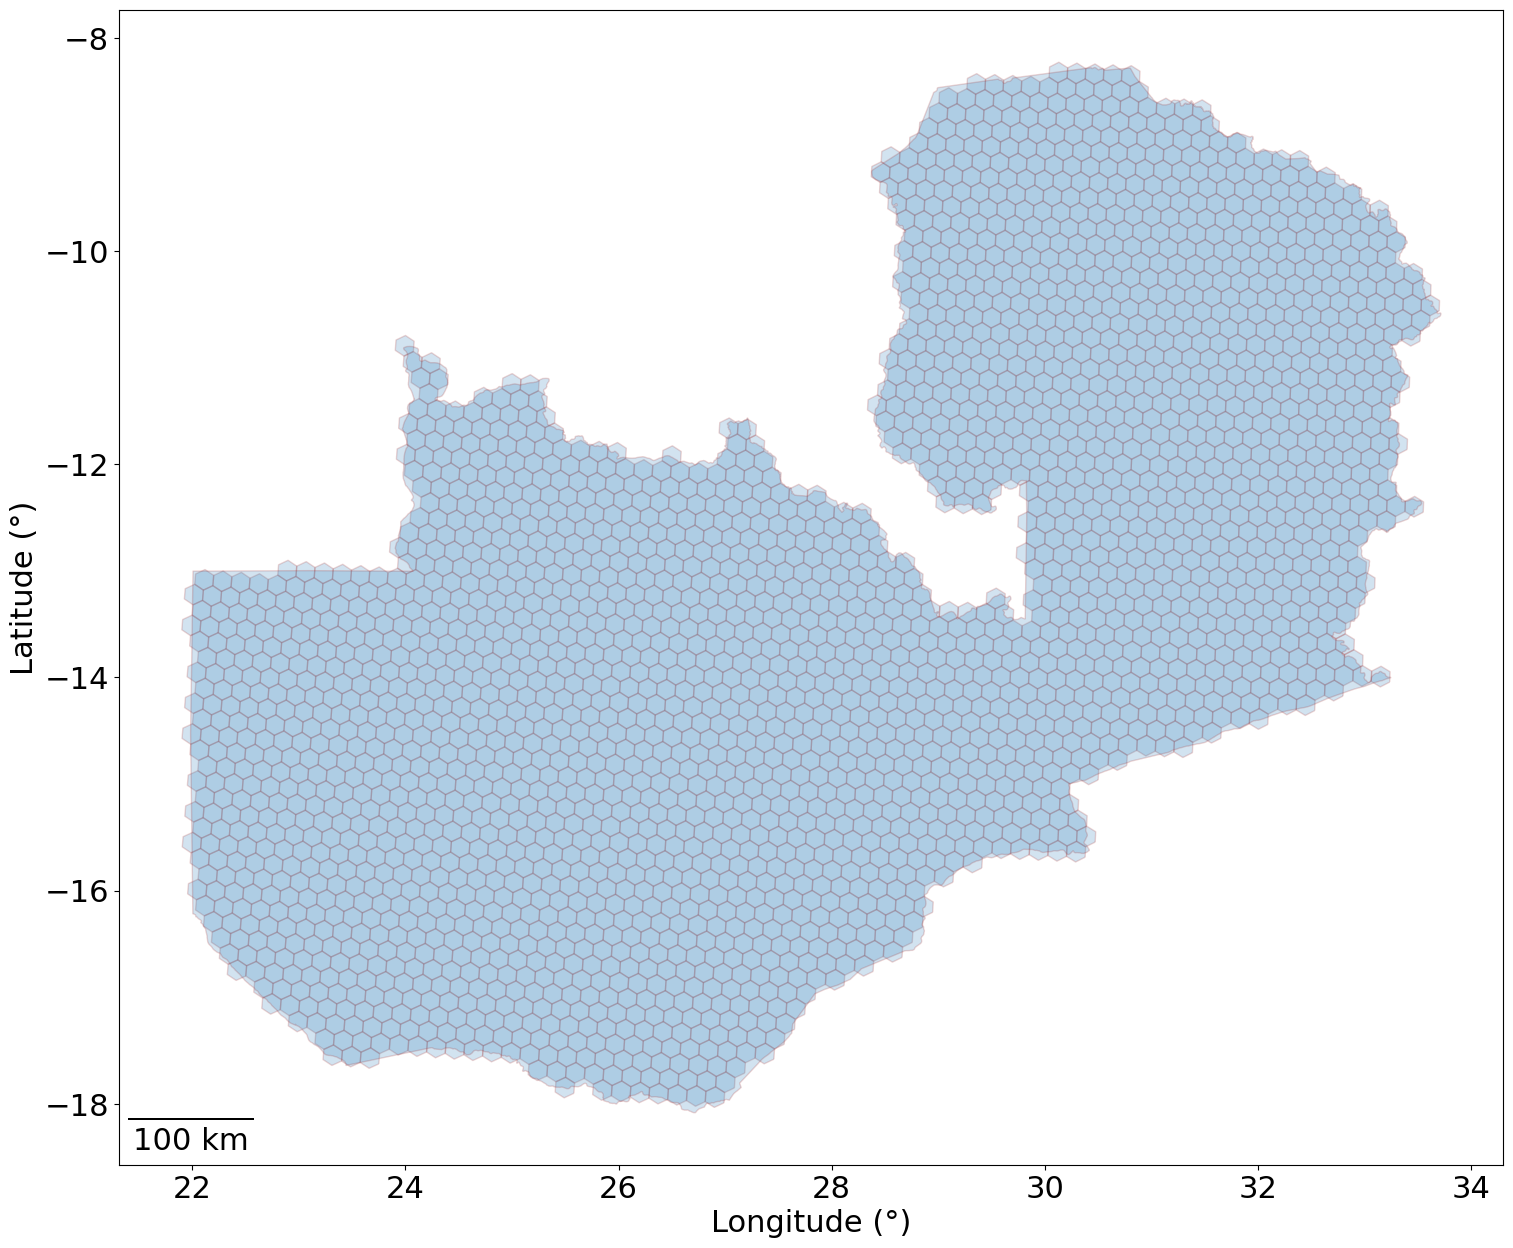

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot basemap
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(25, 15))
# fig, ax = plt.subplots(figsize=(4, 3))


# hex_reproj = hexagons.to_crs(32619)  # Convert the dataset to a coordinate
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
assert admin_gdf.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

plt.show()
# Save plot as figure 
plt.savefig(config.OUTPUT_DIR / 'admin_level_basemap.png', bbox_inches='tight')

In [13]:
hexagons['id'] = range(1, len(hexagons)+1)

In [14]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(config.OUTPUT_DIR / f'h3_grid_at_hex_{size}.shp', index=False)
hexagons.to_file(config.OUTPUT_DIR / config.H3_GRID_HEX_SHP, index=False) # file used in the other scripts
hexagons.to_file(config.OUTPUT_DIR / "hex.geojson")
admin_gdf.to_file(config.OUTPUT_DIR / f'area_gdf.gpkg', index=False)
admin_gdf.to_file(config.OUTPUT_DIR  / f'area_gdf.geojson', driver='GeoJSON', index=False) 